In [100]:
# imports 
import tensorflow as tf
import numpy as np
import pandas as pd
import tensorflow.keras.backend as kb
import matplotlib.pyplot as plt
import time
seed = 1
np.random.seed(seed)

plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['figure.dpi'] = 80

In [101]:
hidden_u = []
m = 200
dim = 2
bounds = [1.6, 4]
# bounds = [2, 2]
n = 90
batch_n = 90
buff = None
epochs = 10000
tol = 1e-5
sgd = tf.keras.optimizers.SGD(learning_rate=3*m, nesterov=True)

x = np.linspace(-bounds[0], bounds[0], 6)
y = np.linspace(-bounds[1], bounds[1], 15)
X, Y = np.meshgrid(x, y)
s = X.shape
data = np.zeros((6*15,dim)) 

# convert mesh into point vector for which the model can be evaluated
c = 0
for i in range(s[0]):
    for j in range(s[1]):
        data[c,0] = X[i,j]
        data[c,1] = Y[i,j]
        c = c+1;

data_points = tf.constant(data, tf.float32) # (n_y, dim)
                   
# van poole equation
def vf(x):
    y = [-x[:,1], x[:,0] - (1-x[:,0]**2)*x[:,1]]
    return y

input_RHS =  tf.transpose(tf.convert_to_tensor(vf(data_points), dtype=tf.float32))  # (n_y, dim)

In [102]:
def get_regularised_bn_mlp(input_shape, m, hidden_units, l2_reg_coeff = None, dropout_rate = None):
    """
    This function is used to build the MLP model. It takes input_shape and hidden_units
    as arguments, which should be used to build the model as described above, using the
    functional API.
    Your function should return the model.
    """
    inputs = tf.keras.layers.Input(shape=(input_shape,), name = 'state')
    h = inputs
    h = tf.keras.layers.Dense(m, activation=tf.math.cos, 
                              kernel_initializer=tf.random_normal_initializer,
                              bias_initializer= tf.random_uniform_initializer(0, 2*  np.pi), 
                              trainable=False, name = '1st_hidden')(inputs)
    h = np.sqrt(2) * h 
    for units in hidden_units:
        h = tf.keras.layers.Dense(units, activation='linear')(h)
    # use bias is false because the derivative of a constant number (bias) is just zero
    outputs = tf.keras.layers.Dense(1, kernel_initializer = tf.zeros_initializer(),activation=None, name = 'output_layer', use_bias=False, trainable=True)(h)
    outputs = outputs / m 
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

model = get_regularised_bn_mlp(input_shape=dim, m = m, hidden_units= hidden_u)
model.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 state (InputLayer)          [(None, 2)]               0         
                                                                 
 1st_hidden (Dense)          (None, 200)               600       
                                                                 
 tf.math.multiply_7 (TFOpLam  (None, 200)              0         
 bda)                                                            
                                                                 
 output_layer (Dense)        (None, 1)                 200       
                                                                 
 tf.math.truediv_7 (TFOpLamb  (None, 1)                0         
 da)                                                             
                                                                 
Total params: 800
Trainable params: 200
Non-trainable para

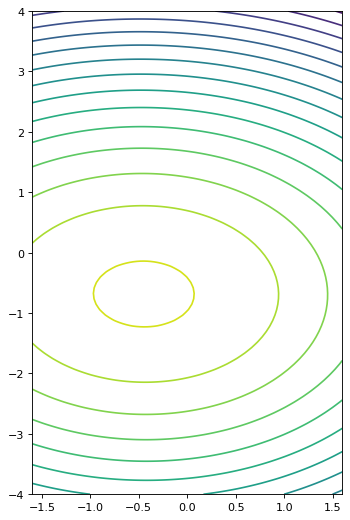

In [103]:
"""Simply plot the Layer without any training to see its initial state"""
x = np.linspace(-bounds[0], bounds[0], n)
y = np.linspace(-bounds[1], bounds[1], n)

X, Y = np.meshgrid(x, y)

s = X.shape

Ze = np.zeros(s)
Zp = np.zeros(s)
DT = np.zeros((n**2,dim))

# convert mesh into point vector for which the model can be evaluated
c = 0
for i in range(s[0]):
    for j in range(s[1]):
        DT[c,0] = X[i,j]
        DT[c,1] = Y[i,j]
        c = c+1;

intermediate_output1 = tf.keras.Model(model.input, model.get_layer('1st_hidden').output)
phi_0 = intermediate_output1(tf.zeros((n, dim)))
# just take the 1st row (all of the others are the same)
phi_0 = phi_0[0]
phi_y = intermediate_output1(DT)
# # check that just a random phi_y would not give the same shape
# phi_y = tf.random.uniform((phi_y.shape))

all1 = tf.tensordot(phi_y, phi_0, 1)

all2 = tf.reshape(all1, (n, n))

plt.figure(figsize=(5,8))
plt.contour(x,y, all2, levels=15)
plt.show()

In [104]:
train_dataset_raw = tf.data.Dataset.from_tensor_slices((data_points, input_RHS))
train_dataset_raw = train_dataset_raw.batch(batch_n)

In [105]:
# Custom tensorflow functions for loss and training

# define the part of the loss function implementing the PDE
# @tf.function
# def grad_loss_eq(gradx, x_batch_train, vf_batch_train):
#     """
#     grad_x: (n, 2)
#     x_batch_train: (n,2)
#     vf_batch_train: (n,2)
    
#     """
#     inner_product = tf.reduce_sum(gradx*vf_batch_train, axis=1) # (n,)
#     # inner_product = tf.reduce_sum(gradx*vf_batch_train)
#     target = tf.square(tf.norm(x_batch_train, ord = 2, axis=1)) # (n,)
#     loss = tf.reduce_sum(tf.abs((inner_product + target))) / len(x_batch_train)
#     # loss = tf.norm((inner_product + target)) / len(x_batch_train)
#     return loss

# with the division by m, lr should be 0.5 for trainable = False
# opt = tf.keras.optimizers.Adam(learning_rate=0.5)
# gradweight = 1

# # this function performs the optimization for a train step
# @tf.function
# def train_step(x_batch_train, vf_batch_train):
#   """
#   x_batch_train: (n,2)
#   vf_batch_train: (n,2)
#   """

# # start gradient recording for derivative w.r.t. model parameters
#   with tf.GradientTape() as tape:
#     # tape.watch(x_batch_train)
#     # start gradient recording for derivative w.r.t. x
#     with tf.GradientTape() as tapex:
#       # prepare for evaluation of x-derivative
#       tapex.watch(x_batch_train)
#       logits2 = model(x_batch_train)

#     # evaluate x-derivative
#     gradx = tapex.gradient(logits2, x_batch_train)

#     # evaluate PDE part of loss function
#     gloss = grad_loss_eq(gradx, x_batch_train, vf_batch_train)
#     # this is the w in the loss equation   
#     loss_value =  gradweight * gloss

#     # evaluate derivative w.r.t. model parameters
#     #changed this
#   grads = tape.gradient(loss_value, model.trainable_weights)

#   # Run one step of gradient descent optimizer
#   #changed this
#   # opt.apply_gradients(zip(grads, model.trainable_weights))
#   sgd.apply_gradients(zip(grads, model.trainable_weights))

#   return(loss_value,gloss)

# @tf.function
# def train_step(x_batch_train, vf_batch_train):
#   """
#   x_batch_train: (n,2)
#   vf_batch_train: (n,2)
#   """

# # start gradient recording for derivative w.r.t. model parameters
#   with tf.GradientTape() as tape:
#     with tf.GradientTape() as tapex:
#       # prepare for evaluation of x-derivative
#       tapex.watch(x_batch_train)
#       logits2 = model(x_batch_train)

#     # evaluate x-derivative
#     gradx = tapex.gradient(logits2, x_batch_train) # (n,2)

#     # evaluate PDE part of loss function
#     inner_product = tf.reduce_sum(gradx*vf_batch_train, axis=1) # (n,)
#     target = tf.square(tf.norm(x_batch_train, ord = 2, axis=1)) # (n,)
#     loss_value = tf.reduce_sum(tf.abs((inner_product + target))) / len(x_batch_train) # scalar
#     gloss = loss_value

#     # evaluate derivative w.r.t. model parameters
#     # changed this
#   grads = tape.gradient(loss_value, model.trainable_weights)

#   # Run one step of gradient descent optimizer
#   #changed this
#   # opt.apply_gradients(zip(grads, model.trainable_weights))
#   sgd.apply_gradients(zip(grads, model.trainable_weights))

#   return(loss_value,gloss)


# @tf.function
# def test_step(x_test, vf_test):

#   # y_pred = model(x_test, training=False)

#   with tf.GradientTape() as tapex:

#     tapex.watch(x_test)
#     # not sure if training should be false here.
#     logits2 = model(x_test, training =False)

#     # evaluate x-derivative
#     #changed this
#   gradx = tapex.gradient(logits2, x_test)

#   loss = grad_loss_eq(gradx, x_test, vf_test)
#   return gradweight * loss

In [106]:
@tf.function
def train_step(x_batch_train, vf_batch_train):
  """
  x_batch_train: (n,2)
  vf_batch_train: (n,2)
  """

# start gradient recording for derivative w.r.t. model parameters
  with tf.GradientTape() as tape:
    with tf.GradientTape() as tapex:
      # prepare for evaluation of x-derivative
      tapex.watch(x_batch_train)
      logits2 = model(x_batch_train) # (n, 1)

    # evaluate x-derivative
    gradx = tapex.gradient(logits2, x_batch_train) # (n,2)

    # evaluate PDE part of loss function

    inner_product = tf.reduce_sum(gradx*vf_batch_train, axis=1) # (n,)
    target = tf.square(tf.norm(x_batch_train, ord = 2, axis=1)) # (n,)
    individual_loss = tf.square(tf.abs((inner_product + target))) # (n,)
    loss_value = tf.reduce_sum(individual_loss) / len(x_batch_train) # scalar

  # evaluate derivative w.r.t. model parameters
  # changed this
  grads = tape.gradient(loss_value, model.trainable_weights) # (m, 1)

  # Run one step of gradient descent optimizer
  # changed this
  # opt.apply_gradients(zip(grads, model.trainable_weights))
  sgd.apply_gradients(zip(grads, model.trainable_weights))

  return(loss_value)


In [107]:
def custom_training_loop(epochs, tol, train_dataset, validation_dataest):

    all_loss_values = []
    all_test_loss_values = []

    # loop through the epochs
    for epoch in range(epochs):
        
        # Iterate over the batches of the dataset
        # in our case only 1 batch so inly 1 loop here
        for step, (x_batch_train, vf_batch_train) in enumerate(train_dataset):

            # call optimization routine
            loss_value = train_step(x_batch_train, vf_batch_train)
            all_loss_values.append(loss_value.numpy())

        # for step, (x_test, vf_test) in enumerate(validation_dataest):
        #     test_loss = test_step(x_test, vf_test)
        #     all_test_loss_values.append(test_loss)

        if epoch % int(epochs/5) == 0:
            print('epoch %2s, loss %10.6f' % (epoch, float(loss_value)))
            
    return all_loss_values, all_test_loss_values

In [108]:
all_loss_values, all_test_loss_values = custom_training_loop(epochs, tol, train_dataset_raw, train_dataset_raw)

epoch  0, loss  83.510109
epoch 2000, loss  12.511728
epoch 4000, loss  10.787938
epoch 6000, loss  10.598285
epoch 8000, loss  10.576863


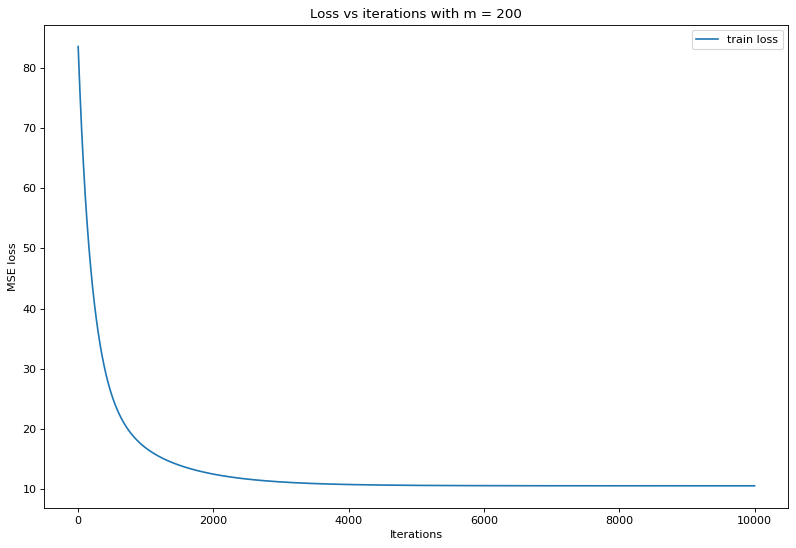

In [109]:
plt.plot(all_loss_values, label = 'train loss')
# plt.xscale('log')
# plt.plot(all_test_loss_values, label = 'test loss')
plt.title("Loss vs iterations with m = {}".format(m))
plt.xlabel("Iterations")
plt.ylabel("MSE loss")
plt.legend()
# plt.xscale('log')
plt.show()

Ep shape is (400, 1)
Shapes: x = (20,), X = (20, 20), DT = (400, 2), Ep = (400, 1), Zp = (20, 20)


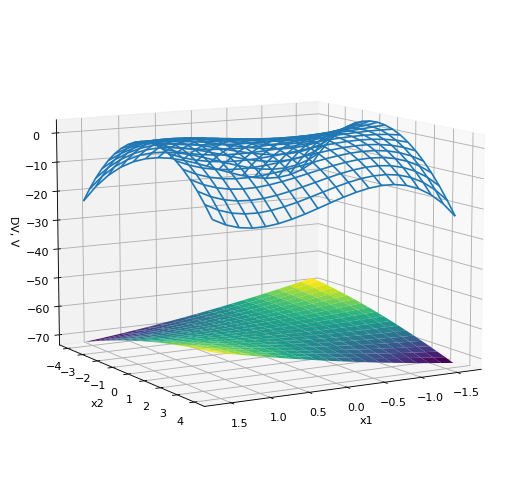

In [110]:
###### plot result ######

# define resolution
numpoints = 20

# define plotting range and mesh
x = np.linspace(-bounds[0], bounds[0], numpoints)
y = np.linspace(-bounds[1], bounds[1], numpoints)

# x = np.linspace(-1, bounds[0], numpoints)
# y = np.linspace(-1, bounds[1], numpoints)

X, Y = np.meshgrid(x, y)

s = X.shape

Ze = np.zeros(s)
Zp = np.zeros(s)
DT = np.zeros((numpoints**2,dim))

# convert mesh into point vector for which the model can be evaluated
c = 0
for i in range(s[0]):
    for j in range(s[1]):
        DT[c,0] = X[i,j]
        DT[c,1] = Y[i,j]
        c = c+1;

# evaluate model (= Lyapunov function values V)
Ep = model.predict(DT)
intermediate_output2 = tf.keras.Model(model.input, model.get_layer('output_layer').output)
# Ep = intermediate_output2(DT)
print('Ep shape is {}'.format(Ep.shape))
# print('Eq shape is {}'.format(Eq.shape))


# convert point vector to tensor for evaluating x-derivative
tDT = tf.convert_to_tensor(DT, dtype=tf.float32)

# evaluate gradients DV of Lyapunov function
with tf.GradientTape() as tape:
    tape.watch(tDT)
    ypm = model(tDT)
    grads = tape.gradient(ypm, tDT)

# compute orbital derivative DVf
Ee = tf.math.reduce_sum(grads*tf.transpose(tf.convert_to_tensor(vf(DT), dtype=tf.float32)), axis=1)

# copy V and DVf values into plottable format
c = 0
for i in range(s[0]):
    for j in range(s[1]):
        Ze[i,j] = Ee[c]
        Zp[i,j] = Ep[c]
        c = c+1;


# define vector field for plot
new_vf = np.reshape(np.array(vf(DT)), (dim, numpoints, numpoints))

print('Shapes: x = {}, X = {}, DT = {}, Ep = {}, Zp = {}'.format(
    x.shape, X.shape, DT.shape, Ep.shape, Zp.shape
))

# define figure
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

# ax.set_title('m = {}'.format(m))
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('DV, V');

# plot values V
ax.plot_surface(X, Y, Zp, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

# plot orbital derivative DVf
ax.plot_wireframe(X, Y, Ze, rstride=1, cstride=1)

# change angles to see graph more clearly
# ax.view_init(-140, 60)
ax.view_init(10, 60)

# plt.savefig('Plots/van_3dplot.pdf')
plt.show()

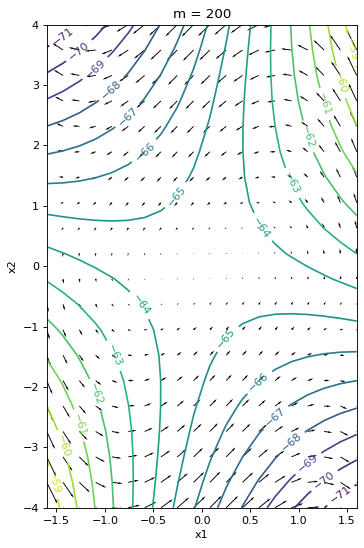

In [111]:
plt.figure(figsize=(5,8))
cp = plt.contour(x,y,Zp, levels=15)
plt.quiver(X,Y, new_vf[0], new_vf[1], headwidth=2, headlength=4)
plt.clabel(cp, inline=True, fontsize=10)
plt.title('m = {}'.format(m))
plt.xlabel('x1')
plt.ylabel('x2')
# plt.savefig('Plots/vanpol2.pdf')
plt.show()

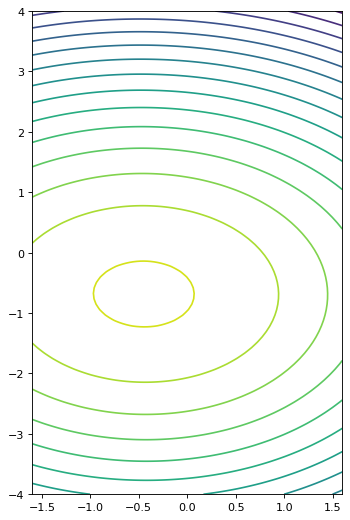

In [112]:
"""Simply plot the Layer without any training to see its initial state"""
x = np.linspace(-bounds[0], bounds[0], n)
y = np.linspace(-bounds[1], bounds[1], n)

X, Y = np.meshgrid(x, y)

s = X.shape

Ze = np.zeros(s)
Zp = np.zeros(s)
DT = np.zeros((n**2,dim))

# convert mesh into point vector for which the model can be evaluated
c = 0
for i in range(s[0]):
    for j in range(s[1]):
        DT[c,0] = X[i,j]
        DT[c,1] = Y[i,j]
        c = c+1;

intermediate_output1 = tf.keras.Model(model.input, model.get_layer('1st_hidden').output)
phi_0 = intermediate_output1(tf.zeros((n, dim)))
# just take the 1st row (all of the others are the same)
phi_0 = phi_0[0]
phi_y = intermediate_output1(DT)
# # check that just a random phi_y would not give the same shape
# phi_y = tf.random.uniform((phi_y.shape))

all1 = tf.tensordot(phi_y, phi_0, 1)

all2 = tf.reshape(all1, (n, n))

plt.figure(figsize=(5,8))
plt.contour(x,y, all2, levels=15)
plt.show()